In [1]:
!pip install pyarrow
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

import pickle

In [2]:
def read_dataframe(file):
    df = pd.read_parquet(file)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime)

    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    return df 

In [3]:
df_train = read_dataframe('./data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2024-02.parquet')

In [4]:
len(df_train), len(df_val)

(54373, 51497)

In [5]:
df_train['PU_DO'] = df_train['PULocationID'] + df_train['DOLocationID' ]
df_val['PU_DO'] = df_val['PULocationID'] + df_val['DOLocationID' ]

In [6]:
numerical = ['trip_distance']
categorical = ['PU_DO']

df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)


dv = DictVectorizer()


train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts )

In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr =  LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

7.631399048385688

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


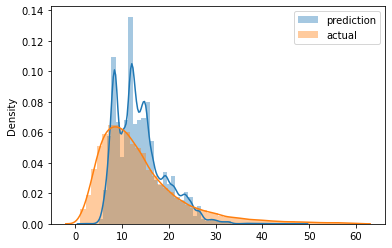

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
with open('./models/lin_reg.bin', 'wb') as f_out:
     pickle.dump((dv, lr), f_out)

In [ ]:
lr =  Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)